# Comparison of CESM FOSI HR cycle 3 and ALT timeseries -- "pseudo-TG" locations

In [75]:
%load_ext autoreload
%autoreload 2

import cartopy.crs as xccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
%matplotlib inline
panellabs=list(map(chr, range(97, 123)))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def plot_map_lg(ax,x,y,z,vmin,vmax,cmap):

    ax.set_global()

    ax.add_feature(cfeature.LAND.with_scale('110m'),color='.9')
    ax.coastlines()
    gl = ax.gridlines(crs=xccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')    
    gl.left_labels = True
    gl.right_labels = False 
    gl.top_labels = False 
    gl.bottom_labels = True
    XTEXT_SIZE = 14
    YTEXT_SIZE = XTEXT_SIZE
    # to facilitate text rotation at bottom edge, ...
    # text justification: 'ha':'right' is used to avoid clashing with map's boundary
    # default of 'ha' is center, often causes trouble when text rotation is not zero
    gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k', 'rotation':0, 'ha':'center'}
    gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}
    gl.xlocator = mticker.FixedLocator([-120,0,120])
    gl.ylocator = mticker.FixedLocator([-60,0,60])
    
    filled=plt.scatter(x=x, y=y, vmin=vmin, vmax=vmax,
            c=z, cmap=cmap,  #this is the changes            
            s=55,
            alpha=1,
            edgecolors= "grey",
            linewidth=1,            
            marker='o',
            zorder=3,
            transform=xccrs.PlateCarree()) ## Important
    # plt.rcParams["axes.edgecolor"] = "black"
    # plt.rcParams["axes.linewidth"] = 1
    return filled

def place_cbar(fig,pname,posin,xshift,yshift,width,height,titin):
    cbar_ax = fig.add_axes([posin.x0+xshift, posin.y0+yshift, width,height])
    cbar=fig.colorbar(pname, orientation='horizontal', cax=cbar_ax)
    cbar.ax.set_title(titin, rotation=0,size=14,weight='bold')

In [77]:
def detrend_df(df):

    df_det=df.copy()
    days = pd.to_datetime(df.index).map(dt.datetime.toordinal)
    trend=[]
    
    for column in df:
        y=df[column]
        not_nan_ind = ~np.isnan(y)
        coefficients = np.polyfit(days[not_nan_ind],y[not_nan_ind],1)    
        fit=np.polyval(coefficients,days)
        df_det[column]=df[column]-fit
        trend.append(coefficients[0])
    return df_det, np.array(trend)*365.25*10

## bring in datasets and preprocess as necessary

### Must run pseudo_tg_locations, cesm2_hr_processing, then alt_processing, to regenerate csv/pkl files

In [86]:
tgs_in=pd.read_csv("pseudo_tgs_in.csv")
# tg_ibcorr = pd.read_pickle("tg_ts_93_18_large.pkl")
alt_ibcorr = pd.read_pickle("pseudo_alt_ts.pkl")
fosi_ibcorr = pd.read_pickle("pseudo_hr3_ts.pkl")
alt_in = pd.read_pickle("pseudo_alt_tg_locs.pkl")
alt_in

name,0,20,40,60,80,120,140,180,200,220,...,9040,9060,9100,9120,9140,9180,9200,9220,9240,9260
Unnamed: 0,0.0,20.0,40.0,60.0,80.0,120.0,140.0,180.0,200.0,220.000000,...,9040.000000,9060.000000,9100.000000,9120.000000,9140.000000,9180.00,9200.000000,9220.000000,9240.000000,9260.00
lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-64.250000,...,7.416667,-5.583333,-5.416667,-8.416667,-8.583333,-20.75,-18.083334,-17.583334,21.083334,19.25
lon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298.583344,...,123.250000,152.083328,155.083328,157.416672,160.583328,165.25,177.250000,210.750000,203.250000,204.75


In [87]:
# # GM REMOVAL FROM NASA PROVIDED MEASURES IPYNB IN MEASURES DIRECTORY
mask=alt_ibcorr*0
gmsl = pd.read_pickle("measures_gmsl.pkl")
gmsl=gmsl/10
gmsl.index=alt_ibcorr.index
gmsl_df=mask
gmsl_df=gmsl_df.add(gmsl, axis=0)
alt_ibcorr=alt_ibcorr-gmsl_df
# subtract from alt

In [88]:
# remove columns where altimetry masked (sea ice)
fosi_ibcorr=fosi_ibcorr+mask
fosi_ibcorr.dropna(axis=1,inplace=True,how='all')
alt_ibcorr.dropna(axis=1,inplace=True,how='all')
alt_in.dropna(axis=1,inplace=True,how='any')

In [89]:
ts1=alt_ibcorr-alt_ibcorr.mean()
ts2=fosi_ibcorr-fosi_ibcorr.mean()

### decompose TSs

In [90]:
focustg=['4000']

In [91]:
ts2_det,ts2_trend = detrend_df(ts2)
ts2_desea=ts2_det.groupby(ts2_det.index.month).transform(lambda x: x-x.mean())
ts2_mean_sea=ts2_det-ts2_desea

In [92]:
ts1_det,ts1_trend = detrend_df(ts1)
ts1_desea=ts1_det.groupby(ts1_det.index.month).transform(lambda x: x-x.mean())
ts1_mean_sea=ts1_det-ts1_desea

### plots

/glade/scratch/clittle/ipykernel_124591/1711178871.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


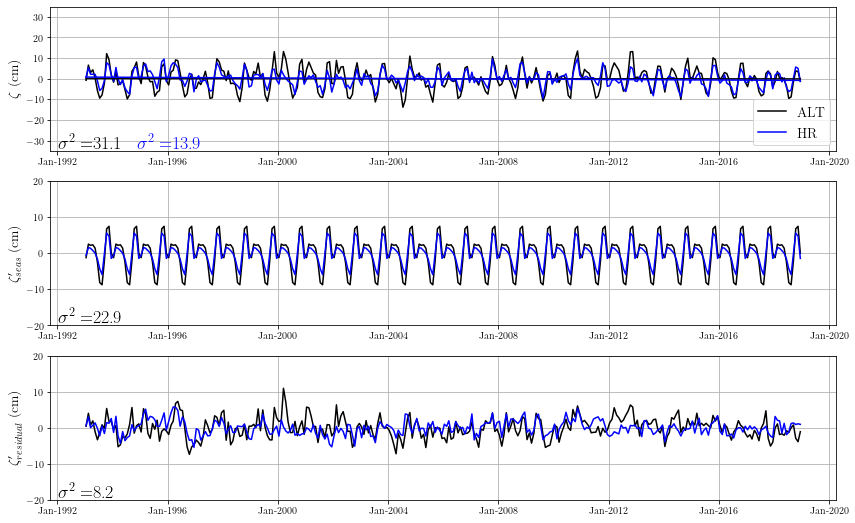

In [93]:
import matplotlib.dates as mdates

mdates.MonthLocator(bymonthday=15)

fig=plt.figure(figsize=(12,12), tight_layout=True)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

ax = plt.subplot2grid((5,1),(1,0), colspan=1, rowspan=1)

l1=ts1[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l2=ts2[focustg]
ax.plot(l2, color='b',ls='-',label='line1');

l3=ts1[focustg]-ts1_det[focustg]
ax.plot(l3, color='k',ls='-',label='line1');

l4=ts2[focustg]-ts2_det[focustg]
ax.plot(l4, color='b',ls='-',label='line1');

ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format((np.std(np.asarray(l1)))**2)),
        transform=ax.transAxes, fontsize=18, weight='bold',color='k')
ax.text(.11,.02, '$\sigma^2=$'+str('{0:.1f}'.format((np.std(np.asarray(l2)))**2)),
        transform=ax.transAxes, fontsize=18, weight='bold',color='b')

ax.legend([],     # The line objects
           labels=["ALT", "HR"],   # The labels for each line
           loc="lower right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=14,# Title for the legend
           )

plt.ylabel("$\zeta$ (cm)",fontsize=14)
plt.xlabel("",fontsize=14)
# ax.text(.01,.85, panellabs[0]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

plt.ylim([-35,35])
plt.grid()


ax = plt.subplot2grid((5,1),(2,0), colspan=1, rowspan=1)

l1=ts1_mean_sea[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l2=ts2_mean_sea[focustg]
ax.plot(l2, color='b',ls='-',label='line1');

plt.ylim([-20,20])
plt.grid()
plt.xlabel("",fontsize=14)
plt.ylabel("$\zeta^{\prime}_{seas}$ (cm)",fontsize=14)
ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format(np.nanstd(np.asarray(l1))**2)), transform=ax.transAxes, fontsize=18, weight='bold',color='k')
# ax.text(.01,.85, panellabs[2]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

    
ax = plt.subplot2grid((5,1),(3,0), colspan=1, rowspan=1)

l1=ts1_desea[focustg]
ax.plot(l1, color='k',ls='-',label='line1');

l2=ts2_desea[focustg]
ax.plot(l2, color='b',ls='-',label='line1');


plt.ylim([-20,20])
plt.grid()
plt.xlabel("",fontsize=14)
plt.ylabel("$\zeta^{\prime}_{residual}$ (cm)",fontsize=14)
ax.text(.01,.02, '$\sigma^2=$'+str('{0:.1f}'.format(np.nanstd(np.asarray(l1))**2)), transform=ax.transAxes, fontsize=18, weight='bold',color='k')
# ax.text(.01,.85, panellabs[3]+')', transform=ax.transAxes, fontsize=18, weight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')
    
# plt.savefig('f2.pdf', dpi=None, 
#         format="pdf",
#         pad_inches = 0,
#         bbox_inches='tight'
#            )

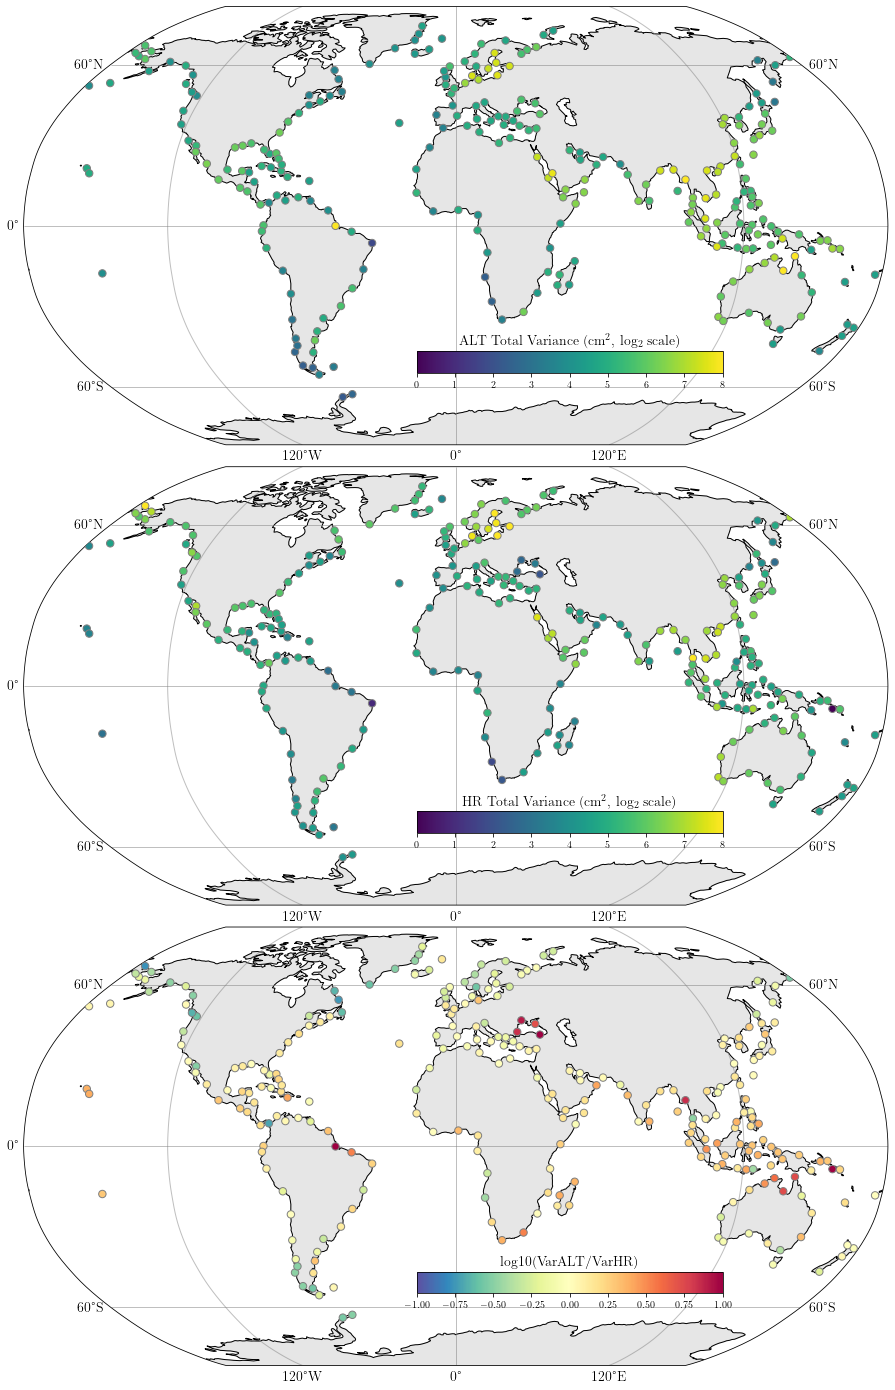

In [94]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR Total Variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Total Variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarALT/VarHR)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

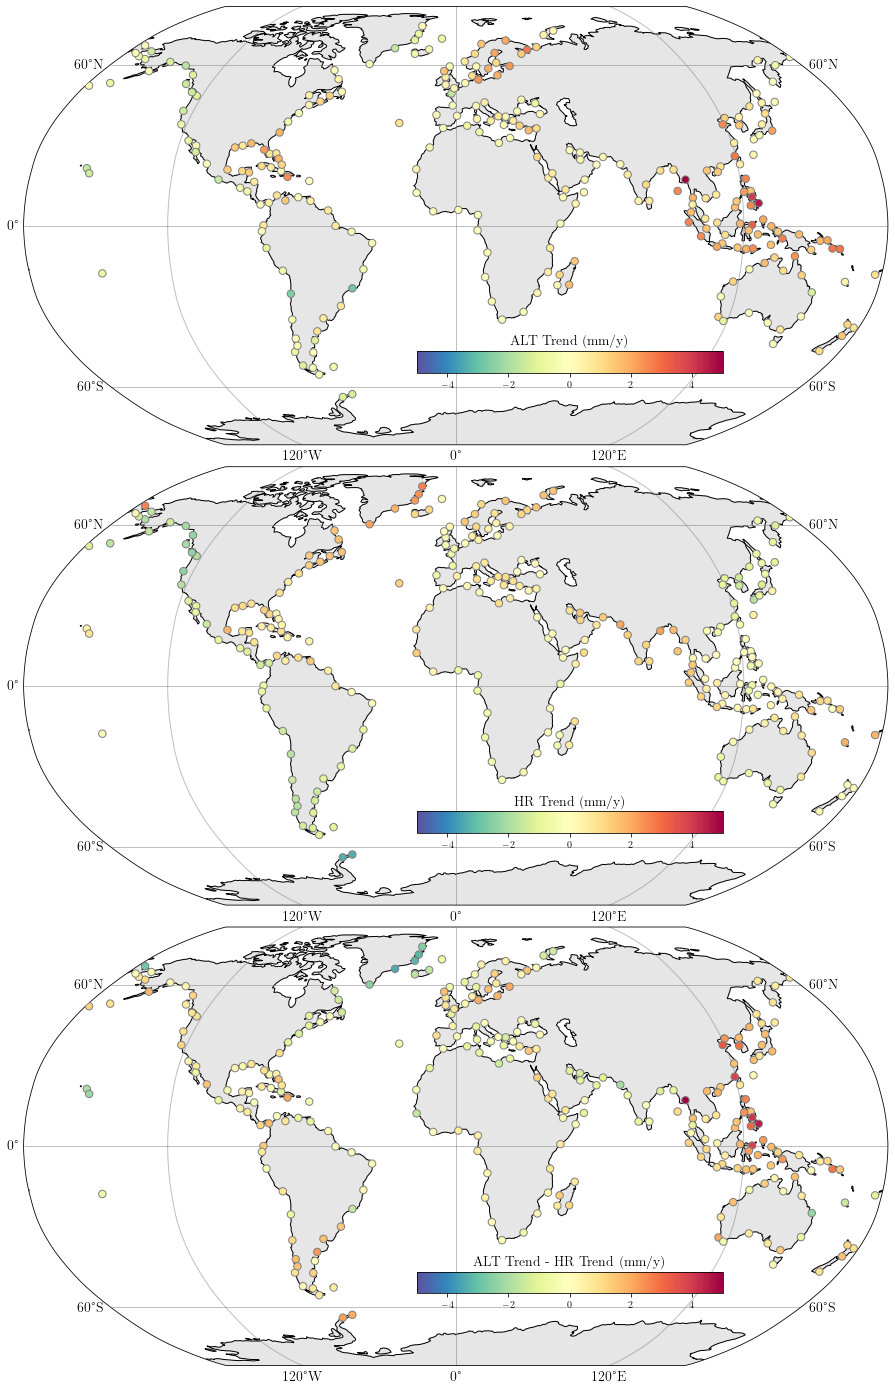

In [95]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=-5
vmax=5
cmap='Spectral_r'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=ts2_trend
# z=z.to_frame()
# z.columns=['cycle3']
# z['cycle2']=ts2_trend2
# z['cycle4']=ts2_trend4
# z=z.mean(axis=1)
z1=z

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR Trend (mm/y)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=ts1_trend
# z=z.to_frame()
# z.columns=['cycle3']
# z['cycle2']=ts1_trend2
# z['cycle4']=ts1_trend4
# z=z.mean(axis=1)
z2=z

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Trend (mm/y)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=z2-z1

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Trend - HR Trend (mm/y)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

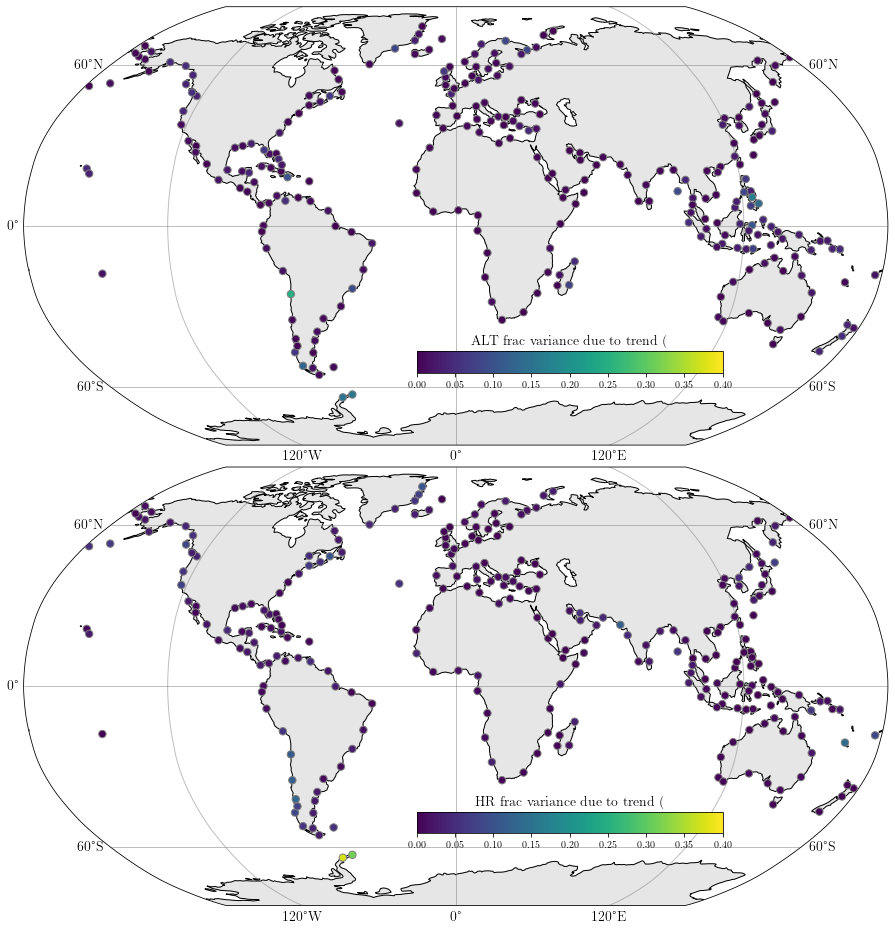

In [96]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=.4
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=1-((np.var(ts2_det))/((np.var(ts2))))

# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR frac variance due to trend (%)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=1-((np.var(ts1_det))/((np.var(ts1))))

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT frac variance due to trend (%)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

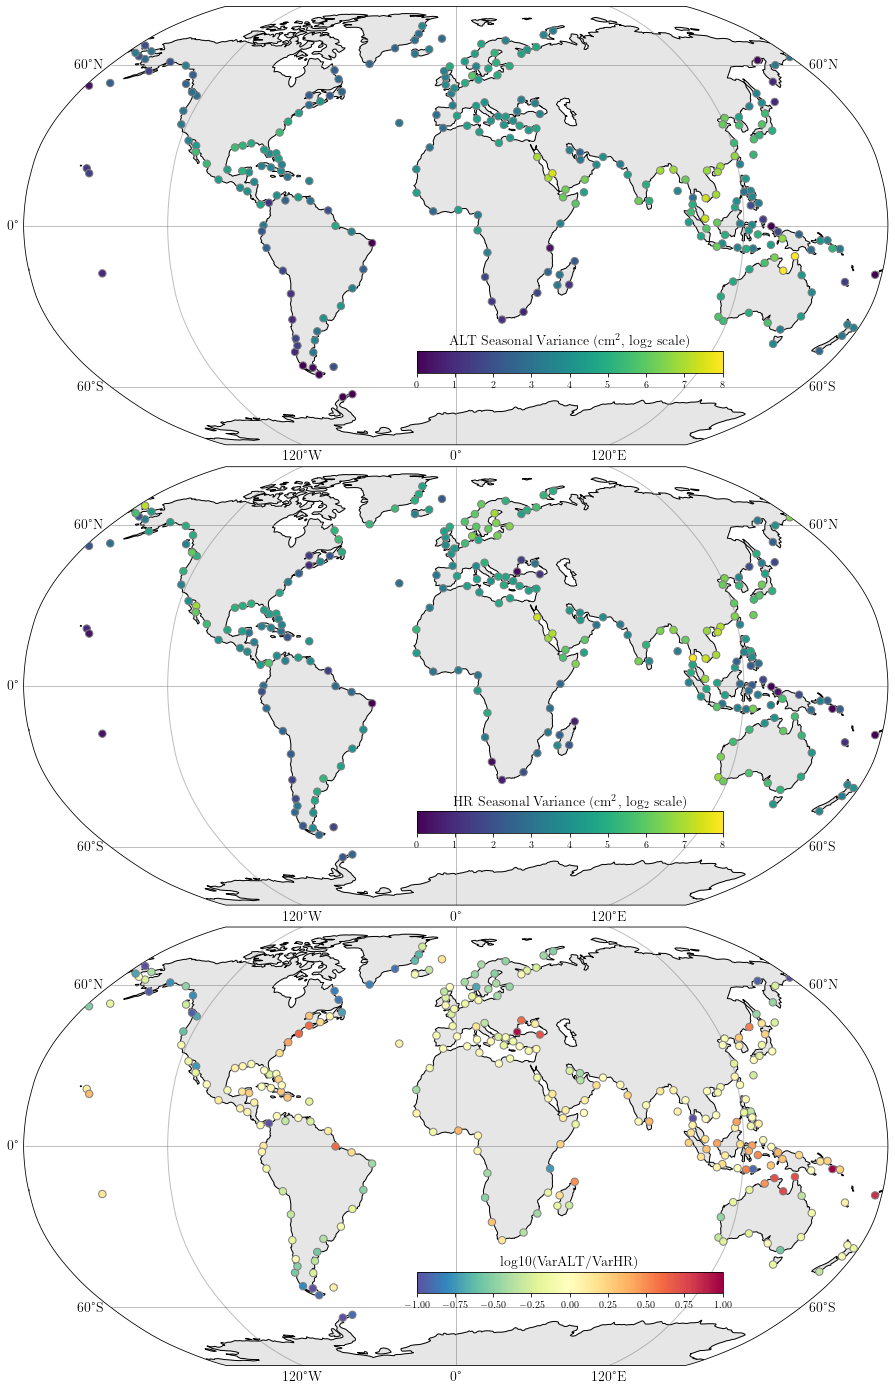

In [97]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2_mean_sea)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR Seasonal Variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1_mean_sea)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT Seasonal Variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarALT/VarHR)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

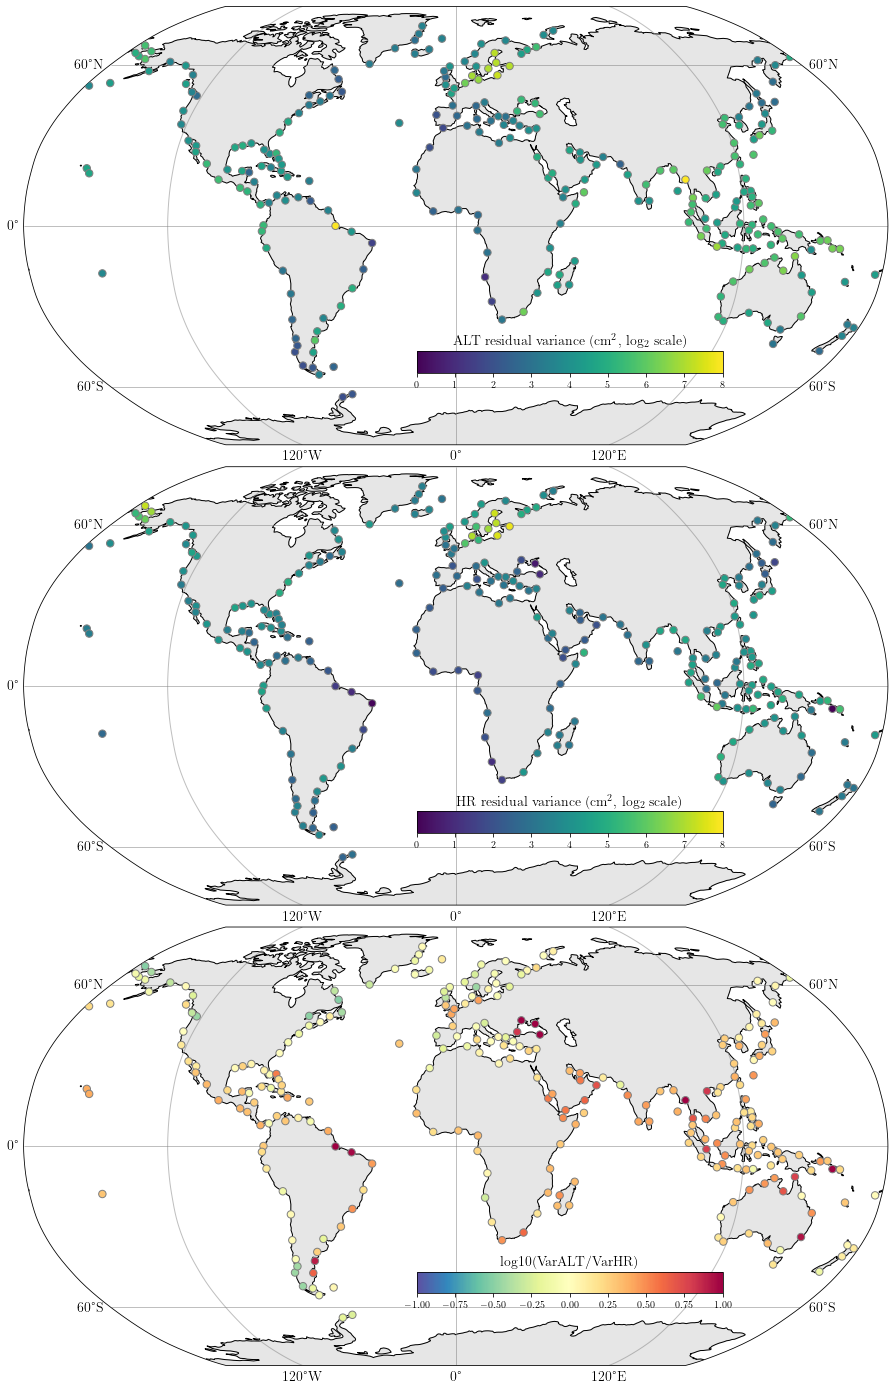

In [98]:
fig = plt.figure(figsize=(25,25))#, tighreset_indexout=True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.1
yshift=.04
cb_w=.17
cb_h=.012

vmin=0
vmax=8
cmap='viridis'

# ax = plt.subplot2grid((1,1), (0, 0), colspan=1, rowspan=1, projection=xccrs.Robinson())
ax = fig.add_subplot(3,1,2, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts2_desea)
z1=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR residual variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

ax = fig.add_subplot(3,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.var(ts1_desea)
z2=z
z=np.log2(z)
# z=z.max(axis=1)-z.min(axis=1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'ALT residual variance (cm$^2$, log$_2$ scale)')
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

vmin=-1
vmax=1
cmap='Spectral_r'

ax = fig.add_subplot(3,1,3, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=np.log10(z2/z1)

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'log10(VarALT/VarHR)')
# fig.colorbar(filled1,fraction=0.046, pad=0.04)
# ax.text(-180,80, panellabs[0]+') ' ,transform=xccrs.PlateCarree(), fontsize=18, weight='bold')

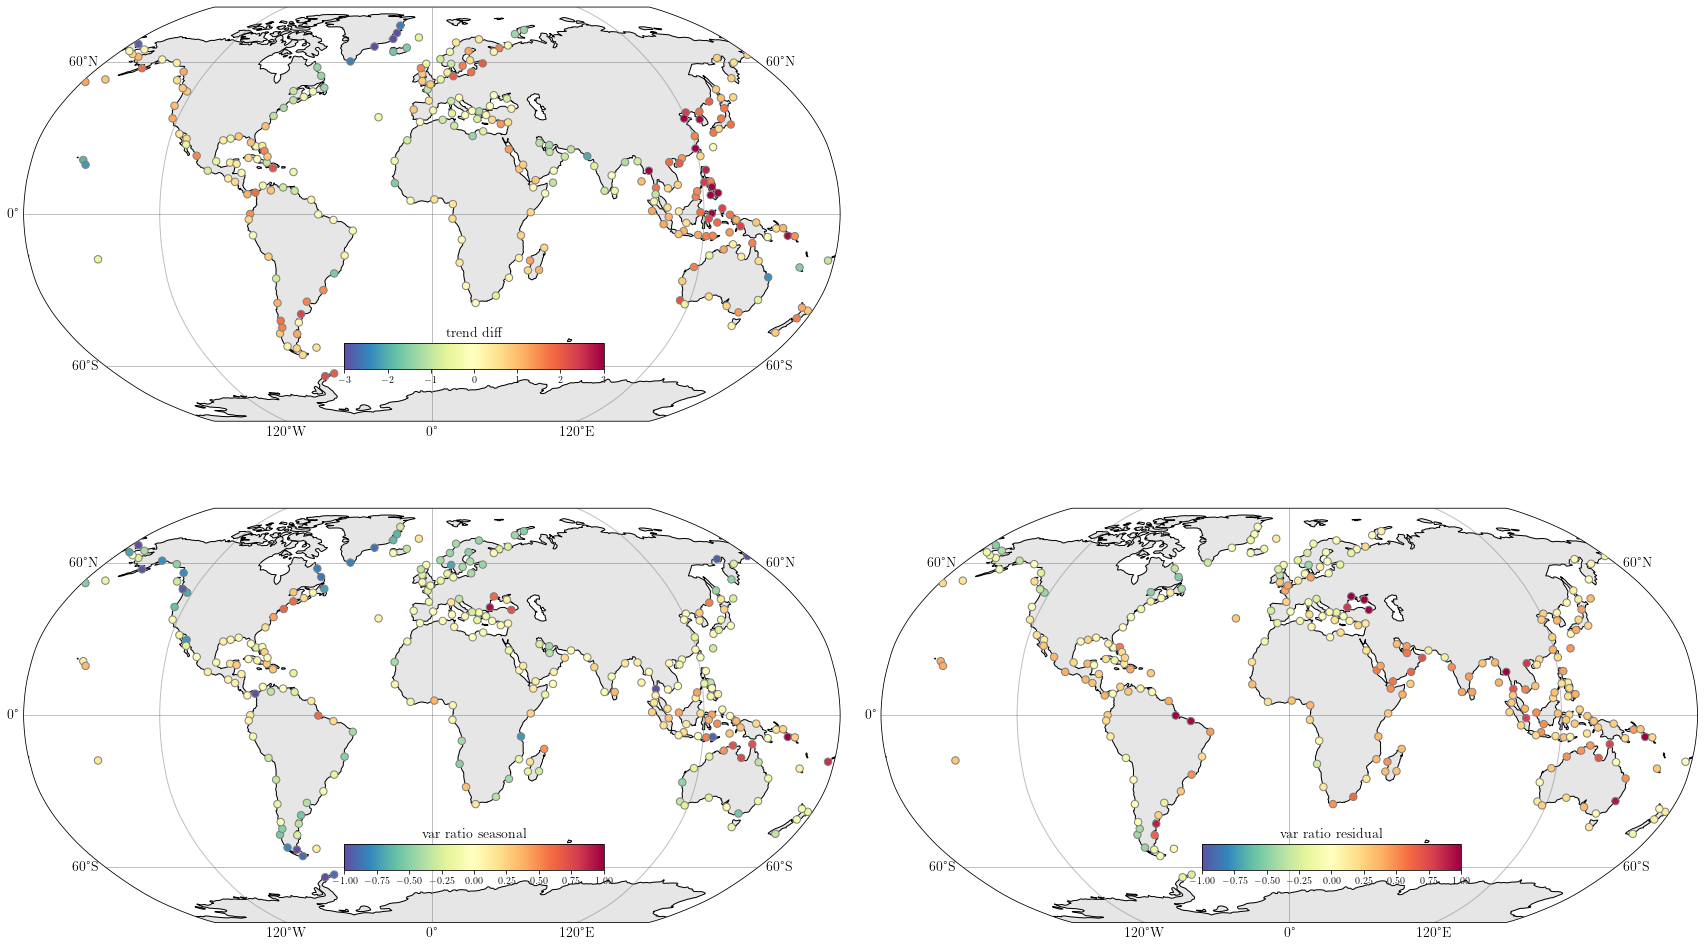

In [99]:
fig = plt.figure(figsize=(30,18))#, tight_layout=True)


# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 0
plt.subplots_adjust(wspace=0.05, hspace=0.05)

xshift=.07
yshift=.065
cb_w=.12
cb_h=.02

cmap='Spectral_r'

z=ts1_trend-ts2_trend
ax = fig.add_subplot(2,2,1, projection=xccrs.Robinson())
vmin = -3
vmax = 3
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'trend diff')

cmap='Spectral_r'
z=np.log10(np.var(ts1_mean_sea)/np.var(ts2_mean_sea))

ax = fig.add_subplot(2,2,3, projection=xccrs.Robinson())
vmin = -1
vmax = 1
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio seasonal')

# z=np.log10(np.var(ts1_hp3)/np.var(ts2_hp3))

# ax = fig.add_subplot(2,2,2, projection=xccrs.Robinson())
# pos = ax.get_position() # get the original position 

# filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
# place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio sub-seasonal')

z=np.log10(np.var(ts1_desea)/np.var(ts2_desea))

ax = fig.add_subplot(2,2,4, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 

filled1=plot_map_lg(ax, alt_in.T.lon, alt_in.T.lat, z, vmin, vmax, cmap)
place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'var ratio residual')